# Super-Resolution Convolutional Neural Network
> In this project, it will show CNN model that can enhance the resolution of image using Convolutional Neural Network. The topic is from the paper "Image Super-Resolution Using Deep Convolutional Networks", presented in ECCV 2014.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Deep_Learning, Vision, Tensorflow-Keras]
- image: images/srcnn_result.png

[Image Super-Resolution Using Deep Convolutional Network](https://arxiv.org/abs/1501.00092) (Dong et al. 2014) introduced the Super-Resolution Convolutional Neural Network (SR-CNN for short) that can enhance the resolution of original image. SR-CNN is deep convolutional neural network that learns end-to-end mapping of low resolution to high resolution image. In this post, we will dig into the basic principles of SR-CNN, and implement it.

## Required Packages

In [ ]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage

## Version check

In [ ]:
print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('Tensorflow: {}'.format(tf.__version__))
print('Matplotlib: {}'.format(mpl.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Numpy: 1.19.5
Pandas: 1.1.5
OpenCV: 4.1.2
Tensorflow: 2.4.1
Matplotlib: 3.2.2
Scikit-Image: 0.16.2


## Metric Functions
Actually, when we saw the raw image, we cannot make sure that this image is whether high resolution image or not. There are several metrics to measure image quality, and we will use

- [Peak Signal to Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) (PSNR)
- Mean Squared Error (MSE)
- [Structural Similarity](https://en.wikipedia.org/wiki/Structural_similarity) (SSIM)

Defined in Wikipedia, **PSNR** is an engineering term for the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation. As you can see the term "Ratio" in words, it is usually expressed in terms of logarithmic decibel (dB) scale, and has following relation,

$$ \text{MSE} = \frac{1}{mn} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1}[I(i, j) - K(i, j)]^2 $$

Here, $I$ is monochrome image and $K$ is its noisy approximation. Expressed in dB scale,

$$ \begin{aligned} PSNR &= 10 \cdot \log_{10} \Big(\frac{\text{MAX}_I^2}{\text{MSE}}\Big) \\ &= 20 \cdot \log_{10}(\text{MAX}_I) - 10 \cdot \log_{10}(\text{MSE}) \end{aligned} $$

From the formula, Image quality will be better if the PSNR value is high, since maximum pixel value is much higher than MSE value.

And **SSIM** is a method for predicting the perceived quality, and it is used for measureing the similarity between two images. If this value is close to 1, then two images are identical. Otherwise, two images will be totally different. Think about it that we can increase PSNR while maintaining the SSIM. That maybe works in CNN. So it is required to define these metrics.

### Peak Signal-to-Noise Ratio (PSNR)

> Note: OpenCV has psnr method (`cv2.psnr`), but we implement this manually here

In [ ]:
def psnr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = np.sqrt(np.mean(diff ** 2.))
    
    return 20 * np.log10(255. / rmse)

### Mean Squared Error (MSE)

In [ ]:
def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= np.float(target_data.shape[0] * target_data.shape[1])
    return err

### Strucutural Similarity
Actually, this metrics is already implemented in skimage.

In [ ]:
from skimage.metrics import structural_similarity as ssim

After we defined our metrics for measuring image quality, we need to combine whole metrics in one metric.

In [ ]:
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores

## **Downloading DataSet**

In [ ]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip

--2021-04-12 22:49:19--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  10.7MB/s    in 9.6s    

2021-04-12 22:49:28 (9.39 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



In [ ]:
import glob
!unzip /content/EuroSAT.zip -d /content/
Euro_images = glob.glob('/content/2750/**/*.jpg') #returns path of images
print(len(Euro_images)) #contains #images

Streaming output truncated to the last 5000 lines.
  inflating: /content/2750/SeaLake/SeaLake_1313.jpg  
  inflating: /content/2750/SeaLake/SeaLake_263.jpg  
  inflating: /content/2750/SeaLake/SeaLake_967.jpg  
  inflating: /content/2750/SeaLake/SeaLake_515.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1465.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1817.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2902.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2570.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1004.jpg  
  inflating: /content/2750/SeaLake/SeaLake_174.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2111.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2388.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1948.jpg  
  inflating: /content/2750/SeaLake/SeaLake_838.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2738.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1999.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2359.jpg  
  inflating: /content/2750/SeaLake/S

In [ ]:
import os
import numpy as np
import shutil
import random

os.makedirs('/content/dataset/SRCNN_dataset/train')
os.makedirs('/content/dataset/SRCNN_dataset/test')

test_ratio = 0.20
allFileNames = os.listdir('/content/2750/')
np.random.shuffle(allFileNames)
train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                             [int(len(allFileNames)* (1 - test_ratio))])


train_FileNames = ['/content/2750/'+ name for name in train_FileNames.tolist()]
test_FileNames = ['/content/2750/'+ name for name in test_FileNames.tolist()]

dst_dir_train = "/content/dataset/SRCNN_dataset/train"
for i in train_FileNames:
      for jpgfile in glob.iglob(os.path.join(i, "*.jpg")):
            shutil.copy(jpgfile, dst_dir_train)

dst_dir_test = "/content/dataset/SRCNN_dataset/test"
for i in test_FileNames:
      for jpgfile in glob.iglob(os.path.join(i, "*.jpg")):
            shutil.copy(jpgfile, dst_dir_test)

In [ ]:
print('Train: ', len(os.listdir('/content/dataset/SRCNN_dataset/train')))
print('Test: ', len(os.listdir('/content/dataset/SRCNN_dataset/test')))

Train:  21500
Test:  5500


## Prepare distorted images via resizing
We need to check the functionality of our metric function, and it requires target and reference image to compare. Thankfully, the original paper published its source code (implemented in Matlab and Caffe) and dataset image in [here](http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html). So we can use it. For the convenience, I downloaded image folder(named `Train` and `Test`) into new directory (`dataset\SRCNN_dataset`)

Then how can we make distorted image from the raw data. It is just simple. After resize down the original image, resize it again to previous width height, then the resolution will be lower since the pixel information may loss during resize.

In [ ]:
def prepare_images(path, factor):
    # Loop through the files in the directory
    for file in os.listdir(path):
        image = cv2.imread(path + '/' + file)
        
        # Find old and new image dimensions
        h, w, c = image.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # Resize down the image
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        
        # Resize up the image
        image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # Save the image
        try:
            os.listdir(path + '/../../resized')
        except:
            os.mkdir(path + '/../../resized')
            
        cv2.imwrite(path + '/../../resized/{}'.format(file), image)

In [ ]:
prepare_images('/content/dataset/SRCNN_dataset/test', 0.75)

Let's see it works.

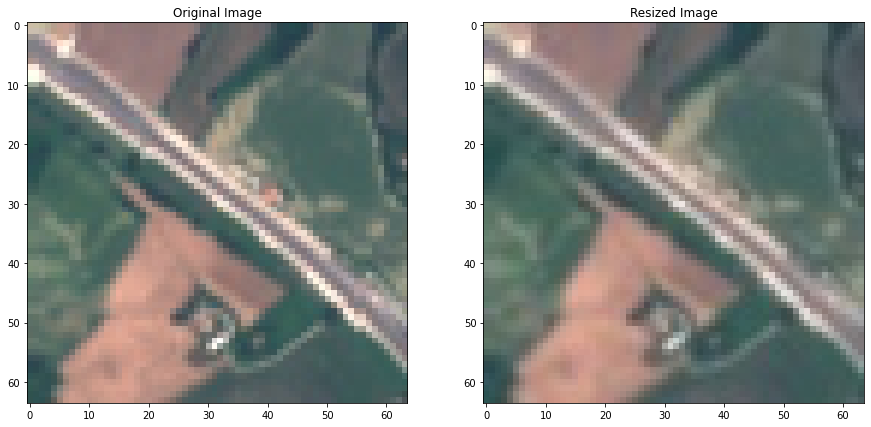

In [ ]:
from PIL import Image
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open('/content/dataset/SRCNN_dataset/test/Highway_1.jpg'))
ax[0].title.set_text('Original Image')
ax[1].imshow(Image.open('/content/dataset/resized/Highway_1.jpg'))
ax[1].title.set_text('Resized Image')
plt.show()

Maybe you can see right image is slightly blurred compared with left image. If we cannot make sure, just use metric function that defined previously.

In [ ]:
target = cv2.imread('/content/dataset/SRCNN_dataset/test/Highway_1.jpg')
ref = cv2.imread('/content/dataset/resized/Highway_1.jpg')

metrics = compare_images(target, ref)
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

PSNR: 33.13808225598335
MSE: 94.70947265625
SSIM: 0.9658062036514377


Actually, there are several transformations for data augmentation, like random crop. [Someone](https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py) made a dataset with h5 format throught script, so we borrow it from there.

In [ ]:
# ref - https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py
# Build train dataset
import h5py

names = sorted(os.listdir('/content/dataset/SRCNN_dataset/train'))

data = []
label = []

for name in names:
    fpath = '/content/dataset/SRCNN_dataset/train/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape
    
    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 0.75), int(shape[0] / 0.75)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    
    width_range = int((shape[0] - 16 * 0.75) / 16)
    height_range = int((shape[1] - 16 * 0.75) / 16)
    
    for k in range(width_range):
        for j in range(height_range):
            x = k * 16
            y = j * 16
            
            hr_patch = hr_img[x: x + 32, y: y + 32]
            lr_patch = lr_img[x: x + 32, y: y + 32]
            
            hr_patch = hr_patch.astype(np.float32) / 255.
            lr_patch = lr_patch.astype(np.float32) / 255.
            
            hr = np.zeros((1, 20, 20), dtype=np.double)
            lr = np.zeros((1, 32, 32), dtype=np.double)
            
            hr[0, :, :] = hr_patch[6:-6, 6: -6]
            lr[0, :, :] = lr_patch
            
            label.append(hr)
            data.append(lr)

data = np.array(data, dtype=np.float32)
label = np.array(label, dtype=np.float32)

In [ ]:
with h5py.File('train.h5', 'w') as h:
    h.create_dataset('data', data=data, shape=data.shape)
    h.create_dataset('label', data=label, shape=label.shape)

In [ ]:
# ref - https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py
# Build test dataset

names = sorted(os.listdir('/content/dataset/SRCNN_dataset/test'))
nums = len(names)

data_test = np.zeros((nums * 30, 1, 32, 32), dtype=np.double)
label_test = np.zeros((nums * 30, 1, 20, 20), dtype=np.double)

for i, name in enumerate(names):
    fpath = '/content/dataset/SRCNN_dataset/test/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape
    
    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 0.75), int(shape[0] / 0.75)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    
    # Produce random crop
    x = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
    y = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
    
    for j in range(30):
        lr_patch = lr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
        hr_patch = hr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
        
        lr_patch = lr_patch.astype(np.float32) / 255.
        hr_patch = hr_patch.astype(np.float32) / 255.
        
        data_test[i * 30 + j, 0, :, :] = lr_patch
        label_test[i * 30 + j, 0, :, :] = hr_patch[6: -6, 6: -6]

In [ ]:
with h5py.File('test.h5', 'w') as h:
    h.create_dataset('data', data=data_test, shape=data_test.shape)
    h.create_dataset('label', data=label_test, shape=label_test.shape)

## Build SR-CNN Model
We prepared our dataset into h5 format. We also need to build SR-CNN model using tensorflow. You already know that keras framework is integrated in tensorflow v2.x. So we can implement it with tensorflow-keras model. In this case, we will build it with sequential model.

In [ ]:
# Define the SR-CNN model
def model():
    SRCNN = tf.keras.Sequential(name='SRCNN')
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(9, 9), 
                                     padding='VALID',
                                     use_bias=True,
                                     input_shape=(None, None, 1),
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                     padding='SAME',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(5, 5),
                                     padding='VALID',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='linear'))
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
    
    # Compile model
    SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error','accuracy'])
    
    return SRCNN

## Train the model
Now, it is time to train the model. How does our model look like?

In [ ]:
srcnn_model = model()
srcnn_model.summary()

Model: "SRCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


Then we load the dataset from prebuilt h5 file. An it will be helpful to define checkpoint.

In [ ]:
with h5py.File('./train.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = np.transpose(data, (0, 2, 3, 1))
    y_train = np.transpose(label, (0, 2, 3, 1))
    
with h5py.File('./test.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = np.transpose(data, (0, 2, 3, 1))
    y_test = np.transpose(label, (0, 2, 3, 1))
    
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((193500, 32, 32, 1),
 (193500, 20, 20, 1),
 (165000, 32, 32, 1),
 (165000, 20, 20, 1))

In [ ]:
checkpoint_path = './srcnn/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_best_only=True,
                                                 save_weights_only=True, verbose=0)

In [ ]:
srcnn_model.fit(X_train, y_train,
                batch_size=64,
                validation_data=(X_test, y_test), 
                callbacks=[checkpoint], shuffle=True, epochs=20, verbose=1)

Epoch 1/20
3024/3024 [==============================] - 31s 10ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - accuracy: 0.0017 - val_loss: 9.1444e-05 - val_mean_squared_error: 9.1444e-05 - val_accuracy: 1.8033e-04
Epoch 2/20
3024/3024 [==============================] - 30s 10ms/step - loss: 4.3338e-05 - mean_squared_error: 4.3338e-05 - accuracy: 0.0016 - val_loss: 8.8043e-05 - val_mean_squared_error: 8.8043e-05 - val_accuracy: 1.8033e-04
Epoch 3/20
3024/3024 [==============================] - 30s 10ms/step - loss: 3.9740e-05 - mean_squared_error: 3.9740e-05 - accuracy: 0.0017 - val_loss: 8.7344e-05 - val_mean_squared_error: 8.7344e-05 - val_accuracy: 1.8033e-04
Epoch 4/20
3024/3024 [==============================] - 31s 10ms/step - loss: 3.7896e-05 - mean_squared_error: 3.7896e-05 - accuracy: 0.0017 - val_loss: 8.6293e-05 - val_mean_squared_error: 8.6293e-05 - val_accuracy: 1.8033e-04
Epoch 5/20
3024/3024 [==============================] - 30s 10ms/step - loss: 3.6098e-05 - mean_

Finally, Training is done. 

## Predict image from model

Let's try it and see its work.

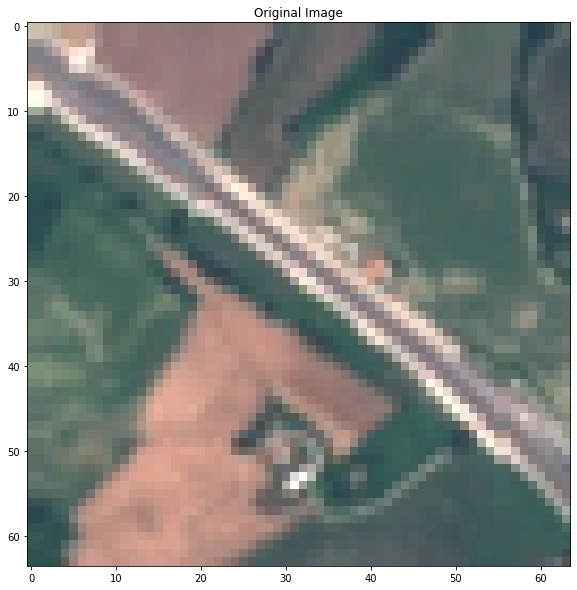

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/content/dataset/SRCNN_dataset/test/Highway_1.jpg'))
ax.title.set_text("Original Image")
plt.show()

Then we need to make distorted image by resizing down and up.

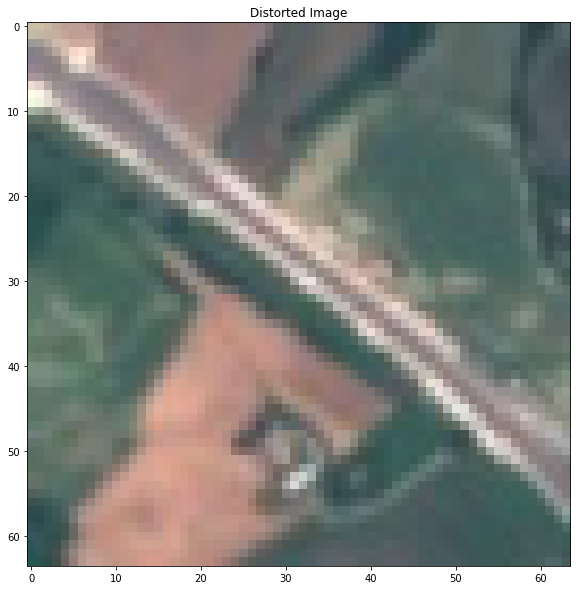

In [ ]:
# Make output directory
try:
    os.listdir('/content/dataset/SRCNN_dataset/output')
except:
    os.mkdir('/content/dataset/SRCNN_dataset/output')

target = cv2.imread('/content/dataset/SRCNN_dataset/test/Highway_1.jpg', cv2.IMREAD_COLOR)
target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
shape = target.shape

# Resize down by scale of 2
Y_img = cv2.resize(target[:, :, 0], (int(shape[1] / 0.75), int(shape[0] / 0.75)), cv2.INTER_CUBIC)

# Resize up to orignal image
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
target[:, :, 0] = Y_img
target = cv2.cvtColor(target, cv2.COLOR_YCrCb2BGR)
cv2.imwrite('/content/dataset/SRCNN_dataset/output/input.jpg', target)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/content/dataset/SRCNN_dataset/output/input.jpg'))
ax.title.set_text("Distorted Image")
plt.show()

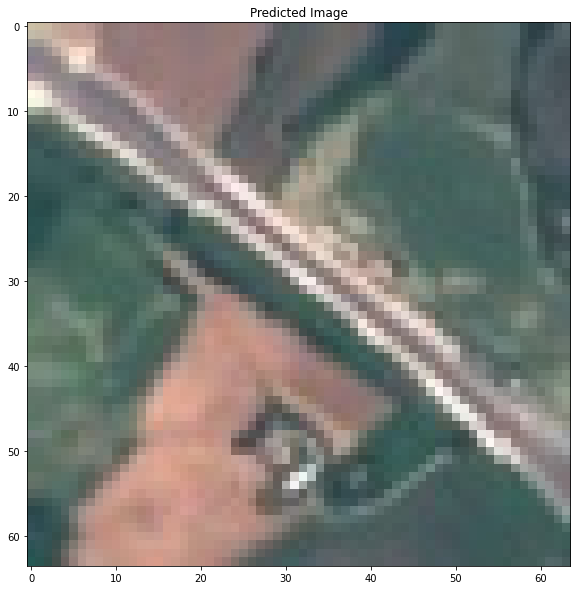

In [ ]:
Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
# Normalize
Y[0, :, :, 0] = Y_img.astype(np.float32) / 255.

# Predict
pre = srcnn_model.predict(Y, batch_size=1) * 255.

# Post process output
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

# Copy y channel back to image and convert to BGR
output = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
output[6: -6, 6: -6, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

# Save image
cv2.imwrite('/content/dataset/SRCNN_dataset/output/output.jpg', output)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/content/dataset/SRCNN_dataset/output/output.jpg'))
ax.title.set_text("Predicted Image")
plt.show()

We can compare those images simultaneously.

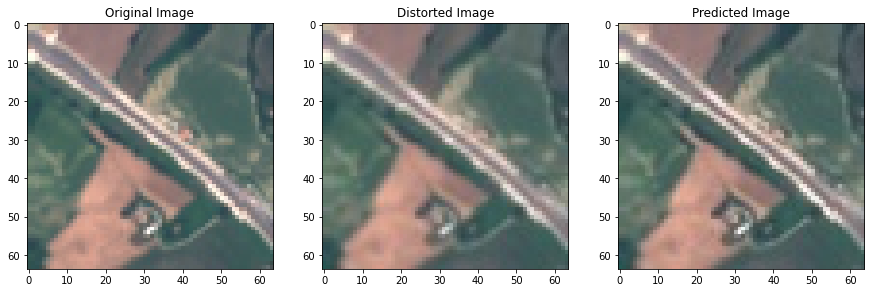

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(Image.open('/content/dataset/SRCNN_dataset/test/Highway_1.jpg'))
ax[0].title.set_text("Original Image")

ax[1].imshow(Image.open('/content/dataset/SRCNN_dataset/output/input.jpg'))
ax[1].title.set_text("Distorted Image")

ax[2].imshow(Image.open('/content/dataset/SRCNN_dataset/output/output.jpg'))
ax[2].title.set_text("Predicted Image")

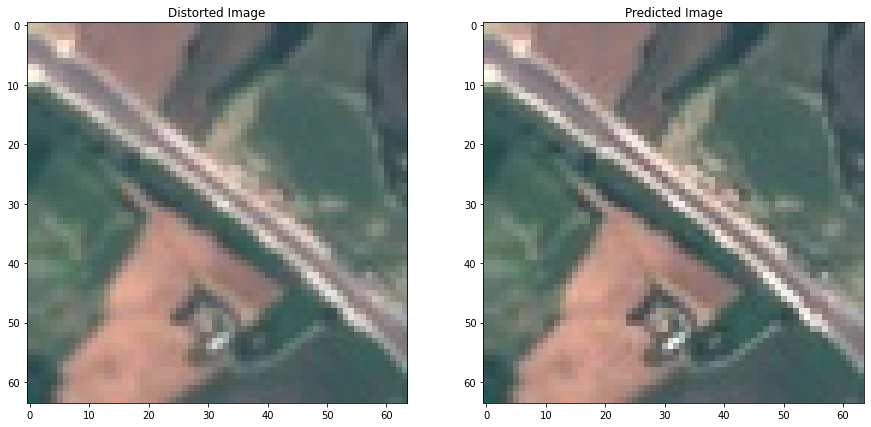

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open('/content/dataset/SRCNN_dataset/output/input.jpg'))
ax[0].title.set_text("Distorted Image")

ax[1].imshow(Image.open('/content/dataset/SRCNN_dataset/output/output.jpg'))
ax[1].title.set_text("Predicted Image")

Here, we can use PSNR and SSIM metrics for comparison. Of course, we need to compare each images with original image.

In [ ]:
original = cv2.imread('/content/dataset/SRCNN_dataset/test/Highway_1.jpg')
distorted = cv2.imread('/content/dataset/SRCNN_dataset/output/input.jpg')
predicted = cv2.imread('/content/dataset/SRCNN_dataset/output/output.jpg')

In [ ]:
# Comparing original and distorted image
metrics = compare_images(original, distorted)
print("Metrics for original and distorted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and distorted image
PSNR: 33.210715953193116
MSE: 93.138671875
SSIM: 0.9655242689983902


In [ ]:
# Comparing original and predicted image
metrics = compare_images(original, predicted)
print("Metrics for original and predicted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and predicted image
PSNR: 36.390486081344044
MSE: 44.787109375
SSIM: 0.9779253323594562


## Summary
We can see that Peak Signal to Noise Ratio of predicted image is higher than that of distorted image, and same in Structural Similarity. As a result, it concludes that SR-CNN model can enhance the image quality, and the predicted output is more similar with original image.